In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
import torchvision.transforms as transforms
import torchvision.models as models

# loading the pretrained model of Vgg_16 which uses batch_normalization
net = models.vgg16_bn(pretrained=True)

# set the load_path for all image file
load_path = './images/'

# set the save_path for the extracted features file for all the classes
save_path = './Feature_extraction_2D/'
#os.mkdir(save_path)
os.makedirs(save_path, exist_ok=True)

# will get the names of the files present in the load path
# The training data
get_class_names = os.listdir(load_path)

# for each class file
get_class_names

for i in get_class_names:
    # To save the file with the same name for the extracted features
    new_save_path = save_path + i
    
    # To load the class file
    class_path = load_path + i

    # to load the numpy file
    img = np.load(class_path)

    # To append the extracted features
    arr = []

    # for each image in the class file
    for j in img:   

        # converting the numpy array to tensor
        j = torch.tensor(j)
        
        # reshaping the image to [batch_size,number_of_channel,height,width]
        j = j.view([-1,3,32,32])
        
        # rescaling the image to [1,3,224,224]
        # vgg_net the required input is of size 224*224 and single image so batch size 1 
        j = F.interpolate(j,(224,224))
        
        # Extracting the features from the middle layer of the network
        z = net.features(j)
        
        # Features extracted are of size [1,512,7,7]
        # Taking the average pooling for each channel
        m = F.avg_pool2d(z,(7,7),1,0)
        
        # Now the features are of size [1,512,1,1]
        #reshaping the features to [512] 
        m = m.view([-1]).detach()
        
        # converting it back to numpy array
        m = np.asarray(m)

        # appending to the arr
        arr.append(m)

    arr = np.asarray(arr)
    print(arr.shape)

    # To save the numpy array  
    np.save(new_save_path,arr)

In [32]:
# for pretty plot confusion matrix

from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sn
import warnings


def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1
#

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
#

def pretty_plot_confusion_matrix(df_cm,st,annot=True, cmap="Oranges", fmt='.2f', fz=20,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sn.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 15)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 15)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix for'+st)
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.ylim([len(df_cm), -.5])
    plt.tight_layout()  #set layout slim
    plt.show()
#

def plot_confusion_matrix_from_data(y_test,st,predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.2f', fz=20, lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='lin'):
    """
        plot confusion matrix function with y_test (actual values) and predictions (predic),
        whitout a confusion matrix yet
    """
    from sklearn.metrics import confusion_matrix
    from pandas import DataFrame

    #data
    if(not columns):
        #labels axis integer:
        ##columns = range(1, len(np.unique(y_test))+1)
        #labels axis string:
        from string import ascii_uppercase
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

    confm = confusion_matrix(y_test, predictions)
    cmap = 'Oranges';
    fz = 20;
    figsize=[9,9];
    show_null_values = 2
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pretty_plot_confusion_matrix(df_cm,st,fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis)
#

def the_plot_conf(test,pred,st):
    """ test function with y_test (actual values) and predictions (predic) """
    #data
    warnings.filterwarnings("ignore")
    y_test = np.array(test)
    predic = np.array(pred)
    """
      Examples to validate output (confusion matrix plot)
        actual: 5 and prediction 1   >>  3
        actual: 2 and prediction 4   >>  1
        actual: 3 and prediction 4   >>  10
    """
    columns = []
    annot = True;
    cmap = 'Oranges';
    fmt = '.2f'
    lw = 0.5
    cbar = False
    show_null_values = 2
    pred_val_axis = 'y'
    #size::
    fz = 20;
    figsize = [9,9];
    if(len(y_test) > 10):
        fz=20; figsize=[14,14];
    plot_confusion_matrix_from_data(y_test," "+st,predic, columns,
      annot, cmap, fmt, fz, lw, cbar, figsize, show_null_values, pred_val_axis)

In [33]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle

In [35]:
path = './Feature_extraction_2D/'
class_names = os.listdir(path)

print(class_names)

['truck.npy', 'plane.npy', 'ship.npy', 'bird.npy', 'horse.npy']


In [36]:
val = 0
data_points = []
data_points_class = []
for i in class_names:
    load_name = os.path.join(path,i)
    extracted_features = np.load(load_name)
    for j in extracted_features:
        data_points.append(j)
        data_points_class.append(val)
    print(val,i)
    val += 1

0 truck.npy
1 plane.npy
2 ship.npy
3 bird.npy
4 horse.npy


In [37]:
temp = list(zip(data_points,data_points_class))
shuffle(temp)

data_points,data_points_class = zip(*temp)
data_points = np.asanyarray(data_points)
data_points_class = np.asanyarray(data_points_class)
print(data_points_class)

[3 2 4 ... 4 3 2]


In [38]:
np.shape(data_points)

(1500, 512)

In [39]:
# setting nodes

dim_hidden_1 = 40
dim_hidden_2 = 28
pca_components = 512
C = 0.01

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data_points, data_points_class,test_size = 0.2)

In [41]:
# from sklearn import decomposition

# pca1 = decomposition.PCA(n_components = pca_components)
# pca1.fit(X_train)
# X_train = pca1.transform(X_train)
# print(X_train.shape)

# pca2 = decomposition.PCA(n_components = pca_components)
# pca2.fit(X_test)
# X_test = pca2.transform(X_test)
# print(X_test.shape)

In [42]:
ytrain = Y_train
b = np.zeros((Y_train.size, Y_train.max()+1))
b[np.arange(Y_train.size),Y_train] = 1
Y_train=b
print(Y_train)

[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [43]:
# Random Initialization and Parameters


learning_rate=0.0005
learning_Rate=0.0005
num_iterations=60000
delta_cost = 1e-8
beta = 0.9
gamma = 0.99
m=1200
lam=0.4
A_W1 = np.random.randn(dim_hidden_1,pca_components) * np.sqrt(2/pca_components)
A_b1 = np.zeros(shape=(dim_hidden_1, 1))
A_W2 = np.random.randn(dim_hidden_2, dim_hidden_1) * np.sqrt(2/dim_hidden_1)
A_b2 = np.zeros(shape=(dim_hidden_2, 1))
A_W3 = np.random.randn(5, dim_hidden_2) * np.sqrt(2/dim_hidden_2)
A_b3 = np.zeros(shape=(5, 1))


cost 0.0 4.7463803468808985
cost 1.0 1.6009539424087265
cost 2.0 1.0319147120385164
cost 3.0 0.8226551180593026
cost 4.0 0.6930202397336831
cost 5.0 0.6715892780660063
cost 6.0 0.5278136852535408
cost 7.0 0.48182557226233513
cost 8.0 0.4476473771884646
cost 9.0 0.4314200288632357
cost 10.0 0.41221432417231135
cost 11.0 0.40115421878800633
cost 12.0 0.39256115208217296
cost 13.0 0.3855700651492522
cost 14.0 0.3794613707453216
cost 15.0 0.37524068161945445
cost 16.0 0.3696357501544194
cost 17.0 0.3931500364951208
cost 18.0 0.36476493770213636


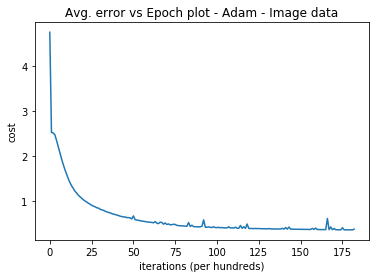

train accuracy = 1.0
test accuracy = 0.21333333333333335


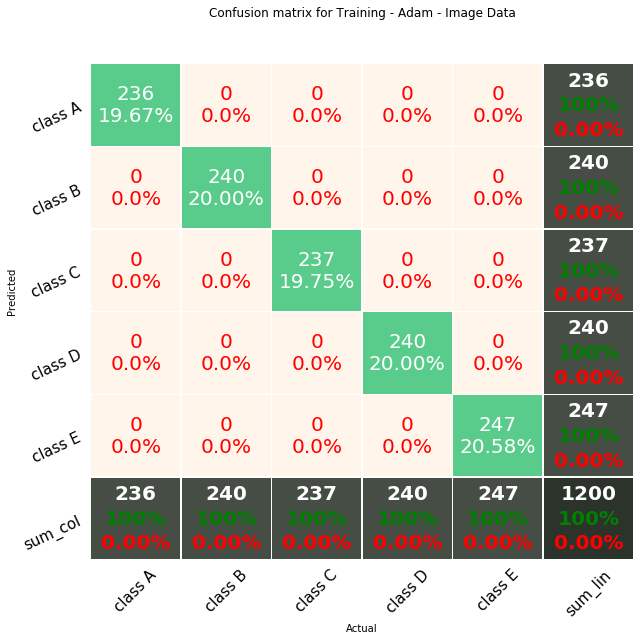

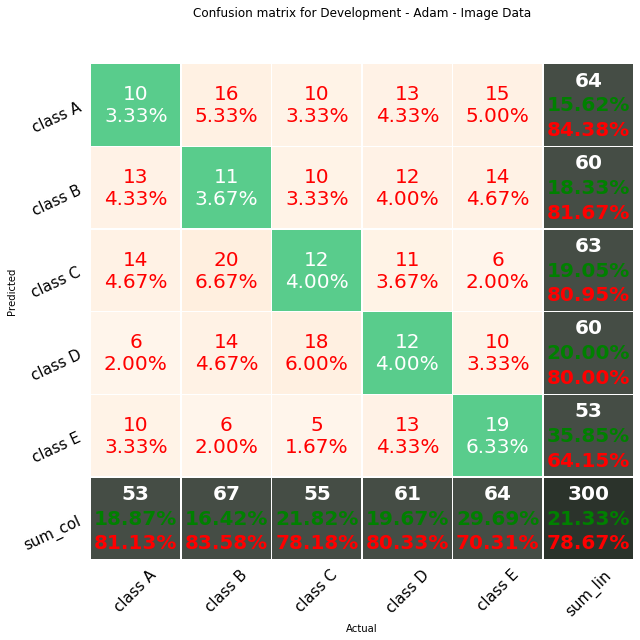

In [44]:
opcode = 2

W1=A_W1
W2=A_W2
W3=A_W3
b1=A_b1
b2=A_b2
b3=A_b3

costs=[]
cost = 0
vW1 = np.zeros_like(W1)
vW2 = np.zeros_like(W2)
vW3 = np.zeros_like(W3)
vb1 = np.zeros_like(b1)
vb2 = np.zeros_like(b2)
vb3 = np.zeros_like(b3)

rvW1 = np.zeros_like(W1)
rvW2 = np.zeros_like(W2)
rvW3 = np.zeros_like(W3)
rvb1 = np.zeros_like(b1)
rvb2 = np.zeros_like(b2)
rvb3 = np.zeros_like(b3)

# Training

for i in range(0, num_iterations):
# forward prop   
    Z1 = np.dot(W1, X_train.T) + b1
    A1 = np.tanh(Z1)
    
    Z2 = np.dot(W2, A1) + b2
    A2 = np.tanh(Z2)
    
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
#  cost    
    prev_cost = cost
    logprobs = np.multiply(np.log(A3), Y_train.T) + np.multiply((1 - Y_train.T), np.log(1 - A3))
    cost =( - np.sum(logprobs) / m)+(lam * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3))) / (2 * m))
    cost = float(np.squeeze(cost))
    if i % 100 == 0:
        costs.append(cost)

# back prop
    dZ3 = A3 - Y_train.T
    dW3 = (1 / m) * np.dot(dZ3, A2.T)+((lam* W3) / m)
    db3 = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)
    dZ2 = np.multiply(np.dot(W3.T, dZ3), 1 - np.power(A2, 2))
    dW2 = (1 / m) * np.dot(dZ2, A1.T)+((lam * W2) / m)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X_train)+(lam * W1) / m
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    if(opcode == 0):
        
        W1 = W1 - learning_rate * dW1
        b1 = b1 - learning_rate * db1
        W2 = W2 - learning_rate * dW2
        b2 = b2 - learning_rate * db2
        W3 = W3 - learning_rate * dW3
        b3 = b3 - learning_rate * db3
        
    else:
        vW1 = beta * vW1 + (1 - beta) * dW1
        vb1 = beta * vb1 + (1 - beta) * db1
        vW2 = beta * vW2 + (1 - beta) * dW2
        vb2 = beta * vb2 + (1 - beta) * db2
        vW3 = beta * vW3 + (1 - beta) * dW3
        vb3 = beta * vb3 + (1 - beta) * db3
        if(opcode == 1):
            
            dW1 = vW1
            db1 = vb1
            dW2 = vW2
            db2 = vb2
            dW3 = vW3
            db3 = vb3
            
            W1 = W1 - learning_rate * dW1
            b1 = b1 - learning_rate * db1
            W2 = W2 - learning_rate * dW2
            b2 = b2 - learning_rate * db2
            W3 = W3 - learning_rate * dW3
            b3 = b3 - learning_rate * db3
            
        else:
            rvW1 = gamma * rvW1 + (1 - gamma) * np.power(dW1,2)
            rvb1 = gamma * rvb1 + (1 - gamma) * np.power(db1,2)
            rvW2 = gamma * rvW2 + (1 - gamma) * np.power(dW2,2)
            rvb2 = gamma * rvb2 + (1 - gamma) * np.power(db2,2)
            rvW3 = gamma * rvW3 + (1 - gamma) * np.power(dW3,2)
            rvb3 = gamma * rvb3 + (1 - gamma) * np.power(db3,2)

            E = 1e-08
            
            vvW1=np.zeros_like(W1)
            vvW2=np.zeros_like(W2)
            vvW3=np.zeros_like(W3)
            vvb1=np.zeros_like(b1)
            vvb2=np.zeros_like(b2)
            vvb3=np.zeros_like(b3)
            
            svW1=np.zeros_like(W1)
            svW2=np.zeros_like(W2)
            svW3=np.zeros_like(W3)
            svb1=np.zeros_like(b1)
            svb2=np.zeros_like(b2)
            svb3=np.zeros_like(b3)


            vvW1 = vW1/(1 - np.power(beta,(i+1)))
            vvb1 = vb1/(1 - np.power(beta,(i+1)))
            vvW2 = vW2/(1 - np.power(beta,(i+1)))
            vvb2 = vb2/(1 - np.power(beta,(i+1)))
            vvW3 = vW3/(1 - np.power(beta,(i+1)))
            vvb3 = vb3/(1 - np.power(beta,(i+1)))

            svW1 = rvW1/(1 - np.power(gamma,(i+1)))
            svb1 = rvb1/(1 - np.power(gamma,(i+1)))
            svW2 = rvW2/(1 - np.power(gamma,(i+1)))
            svb2 = rvb2/(1 - np.power(gamma,(i+1)))
            svW3 = rvW3/(1 - np.power(gamma,(i+1)))
            svb3 = rvb3/(1 - np.power(gamma,(i+1)))
            
            dW1 = vvW1 / np.sqrt(svW1 + E)
            db1 = vvb1 / np.sqrt(svb1 + E)
            dW2 = vvW2 / np.sqrt(svW2 + E)
            db2 = vvb2 / np.sqrt(svb2 + E)
            dW3 = vvW3 / np.sqrt(svW3 + E)
            db3 = vvb3 / np.sqrt(svb3 + E)
            
            W1 = W1 - learning_rate * dW1
            b1 = b1 - learning_rate * db1
            W2 = W2 - learning_rate * dW2
            b2 = b2 - learning_rate * db2
            W3 = W3 - learning_rate * dW3
            b3 = b3 - learning_rate * db3
            
    if(i%1000==0):
        print("cost "+str(i/1000),cost)
        
    if(abs(prev_cost - cost) < delta_cost):
        break

# Avg. error vs Epoch plot

plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Avg. error vs Epoch plot - Adam - Image data")
plt.show()

# Working on training data

Z1 = np.dot(W1, X_train.T) + b1
A1 = np.tanh(Z1)

Z2 = np.dot(W2, A1) + b2
A2 = np.tanh(Z2)

Z3 = np.dot(W3, A2) + b3
A3 = sigmoid(Z3)

pred = np.argmax(A3,axis=0)

# Working on development data




Z1 = np.dot(W1, X_test.T) + b1
A1 = np.tanh(Z1)

Z2 = np.dot(W2, A1) + b2
A2 = np.tanh(Z2)

Z3 = np.dot(W3, A2) + b3
A3 = sigmoid(Z3)

pred1= np.argmax(A3,axis=0)

# accuracy scores

count=0
i=0
while i<1200:
    if(pred[i]==ytrain[i]):
        count=count+1
    i=i+1
print("train accuracy =",count/1200)

count=0
i=0
while i<300:
    if(pred1[i]==Y_test[i]):
        count=count+1
    i=i+1
print("test accuracy =",count/300)

the_plot_conf(pred,ytrain,'Training - Adam - Image Data')

the_plot_conf(pred1,Y_test,'Development - Adam - Image Data')



cost 0.0 4.7463803468808985
cost 1.0 2.527852278509257
cost 2.0 2.5265372703743827
cost 3.0 2.52597484278286
cost 4.0 2.5254254726354235
cost 5.0 2.5248742907211694
cost 6.0 2.5243204251330926
cost 7.0 2.5237634706116814
cost 8.0 2.5232030645998997
cost 9.0 2.522638877146622
cost 10.0 2.5220706147803233
cost 11.0 2.5214980237487574
cost 12.0 2.5209208916842045
cost 13.0 2.5203390471933624
cost 14.0 2.519752356976442
cost 15.0 2.519160720277286
cost 16.0 2.5185640607425803
cost 17.0 2.5179623160853573
cost 18.0 2.51735542625361
cost 19.0 2.516743321041053
cost 20.0 2.516125908194413
cost 21.0 2.5155030630426696
cost 22.0 2.5148746205008625
cost 23.0 2.514240370016668
cost 24.0 2.513600053684684
cost 25.0 2.512953367411181
cost 26.0 2.512299964723212
cost 27.0 2.511639462615381
cost 28.0 2.510971448728457
cost 29.0 2.5102954891499056
cost 30.0 2.509611136197401
cost 31.0 2.5089179356659663
cost 32.0 2.508215433161382
cost 33.0 2.5075031792851674
cost 34.0 2.506780733564549
cost 35.0 2.50

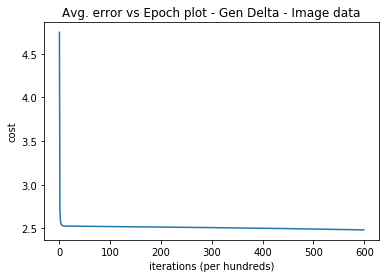

train accuracy = 0.335
test accuracy = 0.2833333333333333


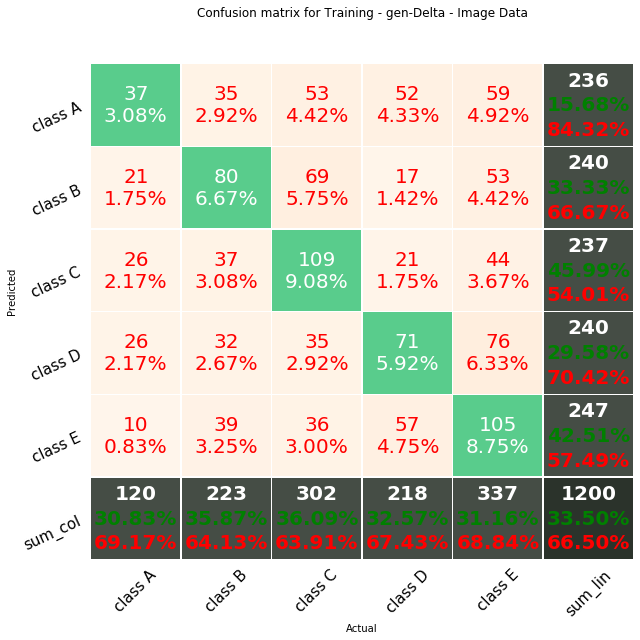

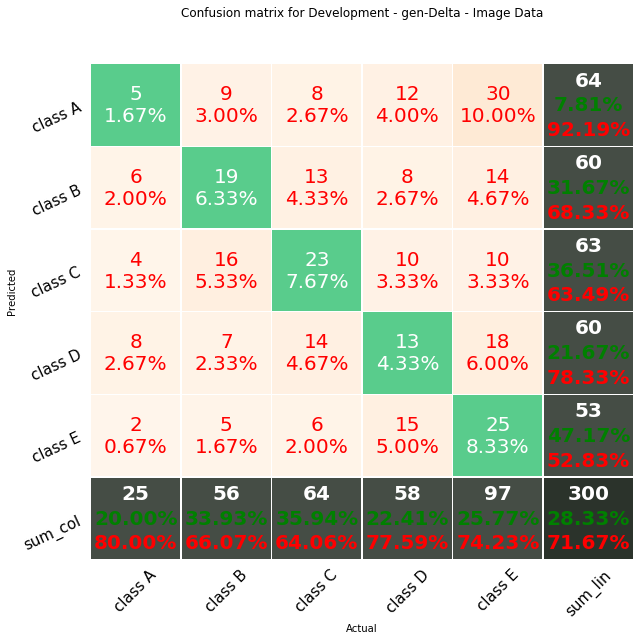

In [45]:
opcode = 1

W1=A_W1
W2=A_W2
W3=A_W3
b1=A_b1
b2=A_b2
b3=A_b3

costs=[]
cost = 0
vW1 = np.zeros_like(W1)
vW2 = np.zeros_like(W2)
vW3 = np.zeros_like(W3)
vb1 = np.zeros_like(b1)
vb2 = np.zeros_like(b2)
vb3 = np.zeros_like(b3)

rvW1 = np.zeros_like(W1)
rvW2 = np.zeros_like(W2)
rvW3 = np.zeros_like(W3)
rvb1 = np.zeros_like(b1)
rvb2 = np.zeros_like(b2)
rvb3 = np.zeros_like(b3)

# Training

for i in range(0, num_iterations):
# forward prop   
    Z1 = np.dot(W1, X_train.T) + b1
    A1 = np.tanh(Z1)
    
    Z2 = np.dot(W2, A1) + b2
    A2 = np.tanh(Z2)
    
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
#  cost    
    prev_cost = cost
    logprobs = np.multiply(np.log(A3), Y_train.T) + np.multiply((1 - Y_train.T), np.log(1 - A3))
    cost =( - np.sum(logprobs) / m)+(lam * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3))) / (2 * m))
    cost = float(np.squeeze(cost))
    if i % 100 == 0:
        costs.append(cost)

# back prop
    dZ3 = A3 - Y_train.T
    dW3 = (1 / m) * np.dot(dZ3, A2.T)+((lam* W3) / m)
    db3 = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)
    dZ2 = np.multiply(np.dot(W3.T, dZ3), 1 - np.power(A2, 2))
    dW2 = (1 / m) * np.dot(dZ2, A1.T)+((lam * W2) / m)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X_train)+(lam * W1) / m
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    if(opcode == 0):
        
        W1 = W1 - learning_rate * dW1
        b1 = b1 - learning_rate * db1
        W2 = W2 - learning_rate * dW2
        b2 = b2 - learning_rate * db2
        W3 = W3 - learning_rate * dW3
        b3 = b3 - learning_rate * db3
        
    else:
        vW1 = beta * vW1 + (1 - beta) * dW1
        vb1 = beta * vb1 + (1 - beta) * db1
        vW2 = beta * vW2 + (1 - beta) * dW2
        vb2 = beta * vb2 + (1 - beta) * db2
        vW3 = beta * vW3 + (1 - beta) * dW3
        vb3 = beta * vb3 + (1 - beta) * db3
        if(opcode == 1):
            
            W1 = W1 - learning_rate * vW1
            b1 = b1 - learning_rate * vb1
            W2 = W2 - learning_rate * vW2
            b2 = b2 - learning_rate * vb2
            W3 = W3 - learning_rate * vW3
            b3 = b3 - learning_rate * vb3
            
        else:
            rvW1 = gamma * rvW1 + (1 - gamma) * np.power(dW1,2)
            rvb1 = gamma * rvb1 + (1 - gamma) * np.power(db1,2)
            rvW2 = gamma * rvW2 + (1 - gamma) * np.power(dW2,2)
            rvb2 = gamma * rvb2 + (1 - gamma) * np.power(db2,2)
            rvW3 = gamma * rvW3 + (1 - gamma) * np.power(dW3,2)
            rvb3 = gamma * rvb3 + (1 - gamma) * np.power(db3,2)

            E = 1e-08
            
            vvW1=np.zeros_like(W1)
            vvW2=np.zeros_like(W2)
            vvW3=np.zeros_like(W3)
            vvb1=np.zeros_like(b1)
            vvb2=np.zeros_like(b2)
            vvb3=np.zeros_like(b3)
            
            svW1=np.zeros_like(W1)
            svW2=np.zeros_like(W2)
            svW3=np.zeros_like(W3)
            svb1=np.zeros_like(b1)
            svb2=np.zeros_like(b2)
            svb3=np.zeros_like(b3)


            vvW1 = vW1/(1 - np.power(beta,(i+1)))
            vvb1 = vb1/(1 - np.power(beta,(i+1)))
            vvW2 = vW2/(1 - np.power(beta,(i+1)))
            vvb2 = vb2/(1 - np.power(beta,(i+1)))
            vvW3 = vW3/(1 - np.power(beta,(i+1)))
            vvb3 = vb3/(1 - np.power(beta,(i+1)))

            svW1 = rvW1/(1 - np.power(gamma,(i+1)))
            svb1 = rvb1/(1 - np.power(gamma,(i+1)))
            svW2 = rvW2/(1 - np.power(gamma,(i+1)))
            svb2 = rvb2/(1 - np.power(gamma,(i+1)))
            svW3 = rvW3/(1 - np.power(gamma,(i+1)))
            svb3 = rvb3/(1 - np.power(gamma,(i+1)))
            
            dW1 = vvW1 / np.sqrt(svW1 + E)
            db1 = vvb1 / np.sqrt(svb1 + E)
            dW2 = vvW2 / np.sqrt(svW2 + E)
            db2 = vvb2 / np.sqrt(svb2 + E)
            dW3 = vvW3 / np.sqrt(svW3 + E)
            db3 = vvb3 / np.sqrt(svb3 + E)
            
            W1 = W1 - learning_rate * dW1
            b1 = b1 - learning_rate * db1
            W2 = W2 - learning_rate * dW2
            b2 = b2 - learning_rate * db2
            W3 = W3 - learning_rate * dW3
            b3 = b3 - learning_rate * db3
            
    if(i%1000==0):
        print("cost "+str(i/1000),cost)        
    if(abs(prev_cost - cost) < delta_cost):
        break

# Avg. error vs Epoch plot

plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Avg. error vs Epoch plot - Gen Delta - Image data")
plt.show()

# Working on training data

Z1 = np.dot(W1, X_train.T) + b1
A1 = np.tanh(Z1)

Z2 = np.dot(W2, A1) + b2
A2 = np.tanh(Z2)

Z3 = np.dot(W3, A2) + b3
A3 = sigmoid(Z3)

pred = np.argmax(A3,axis=0)

# Working on development data




Z1 = np.dot(W1, X_test.T) + b1
A1 = np.tanh(Z1)

Z2 = np.dot(W2, A1) + b2
A2 = np.tanh(Z2)

Z3 = np.dot(W3, A2) + b3
A3 = sigmoid(Z3)

pred1= np.argmax(A3,axis=0)

# accuracy scores

count=0
i=0
while i<1200:
    if(pred[i]==ytrain[i]):
        count=count+1
    i=i+1
print("train accuracy =",count/1200)

count=0
i=0
while i<300:
    if(pred1[i]==Y_test[i]):
        count=count+1
    i=i+1
print("test accuracy =",count/300)

the_plot_conf(pred,ytrain,'Training - gen-Delta - Image Data')

the_plot_conf(pred1,Y_test,'Development - gen-Delta - Image Data')



cost 0.0 4.7463803468808985
cost 1.0 2.5278827477932184
cost 2.0 2.5265224894262768
cost 3.0 2.5259554844477012
cost 4.0 2.5254025782431335
cost 5.0 2.5248478519578756
cost 6.0 2.524290390754981
cost 7.0 2.5237297976607276
cost 8.0 2.523165723506641
cost 9.0 2.522597854241477
cost 10.0 2.522025914339179
cost 11.0 2.5214496694403024
cost 12.0 2.520868927182373
cost 13.0 2.520283535749699
cost 14.0 2.519693379819652
cost 15.0 2.5190983738152966
cost 16.0 2.518498452674959
cost 17.0 2.517893560671265
cost 18.0 2.5172836390981397
cost 19.0 2.5166686138374463
cost 20.0 2.5160483838750554
cost 21.0 2.5154228117437447
cost 22.0 2.514791716643009
cost 23.0 2.5141548706665446
cost 24.0 2.5135119982149488
cost 25.0 2.512862778343028
cost 26.0 2.512206849534291
cost 27.0 2.511543816235798
cost 28.0 2.5108732564290093
cost 29.0 2.5101947295433016
cost 30.0 2.509507784114727
cost 31.0 2.5088119647258913
cost 32.0 2.5081068179087858
cost 33.0 2.507391896831574
cost 34.0 2.5066667647104315
cost 35.0 

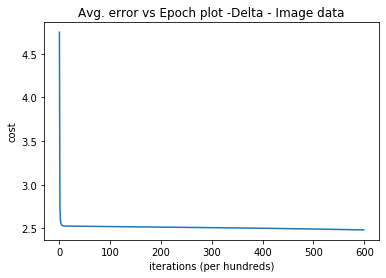

train accuracy = 0.335
test accuracy = 0.2833333333333333


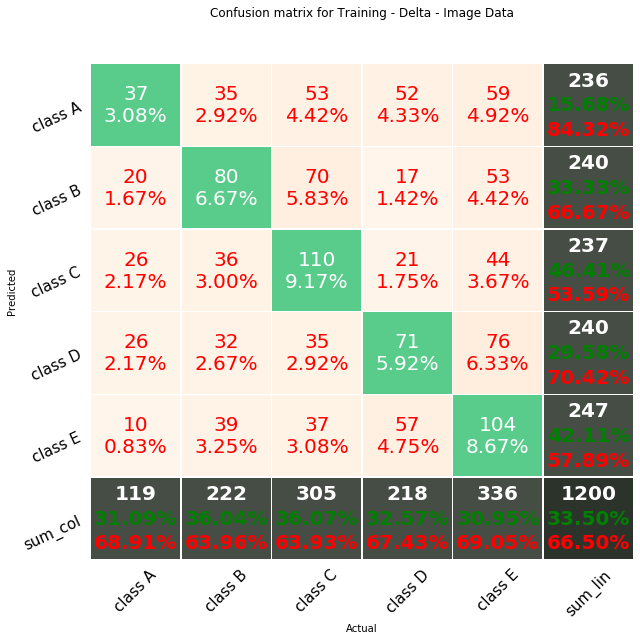

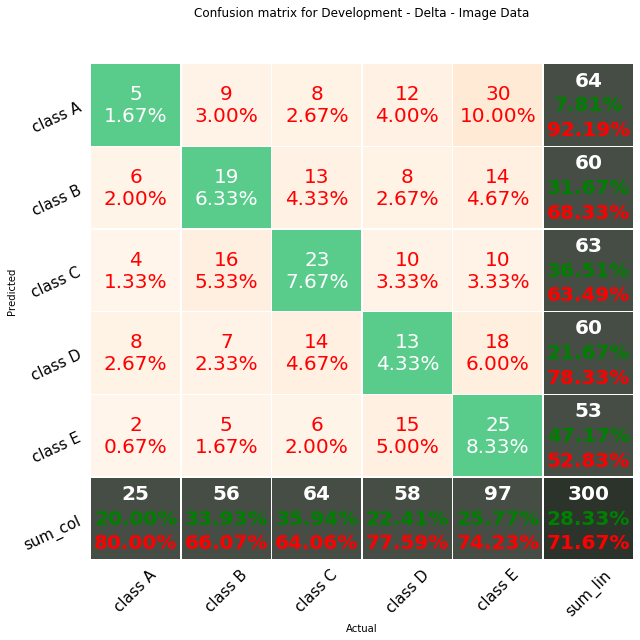

In [46]:
opcode = 0

W1=A_W1
W2=A_W2
W3=A_W3
b1=A_b1
b2=A_b2
b3=A_b3

costs=[]
cost = 0
vW1 = np.zeros_like(W1)
vW2 = np.zeros_like(W2)
vW3 = np.zeros_like(W3)
vb1 = np.zeros_like(b1)
vb2 = np.zeros_like(b2)
vb3 = np.zeros_like(b3)

rvW1 = np.zeros_like(W1)
rvW2 = np.zeros_like(W2)
rvW3 = np.zeros_like(W3)
rvb1 = np.zeros_like(b1)
rvb2 = np.zeros_like(b2)
rvb3 = np.zeros_like(b3)

# Training

for i in range(0, num_iterations):
# forward prop   
    Z1 = np.dot(W1, X_train.T) + b1
    A1 = np.tanh(Z1)
    
    Z2 = np.dot(W2, A1) + b2
    A2 = np.tanh(Z2)
    
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
#  cost    
    prev_cost = cost
    logprobs = np.multiply(np.log(A3), Y_train.T) + np.multiply((1 - Y_train.T), np.log(1 - A3))
    cost =( - np.sum(logprobs) / m)+(lam * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3))) / (2 * m))
    cost = float(np.squeeze(cost))
    if i % 100 == 0:
        costs.append(cost)

# back prop
    dZ3 = A3 - Y_train.T
    dW3 = (1 / m) * np.dot(dZ3, A2.T)+((lam* W3) / m)
    db3 = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)
    dZ2 = np.multiply(np.dot(W3.T, dZ3), 1 - np.power(A2, 2))
    dW2 = (1 / m) * np.dot(dZ2, A1.T)+((lam * W2) / m)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X_train)+(lam * W1) / m
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    if(opcode == 0):
        
        W1 = W1 - learning_rate * dW1
        b1 = b1 - learning_rate * db1
        W2 = W2 - learning_rate * dW2
        b2 = b2 - learning_rate * db2
        W3 = W3 - learning_rate * dW3
        b3 = b3 - learning_rate * db3
        
    else:
        vW1 = beta * vW1 + (1 - beta) * dW1
        vb1 = beta * vb1 + (1 - beta) * db1
        vW2 = beta * vW2 + (1 - beta) * dW2
        vb2 = beta * vb2 + (1 - beta) * db2
        vW3 = beta * vW3 + (1 - beta) * dW3
        vb3 = beta * vb3 + (1 - beta) * db3
        if(opcode == 1):
            
            dW1 = vW1
            db1 = vb1
            dW2 = vW2
            db2 = vb2
            dW3 = vW3
            db3 = vb3
            
            W1 = W1 - learning_rate * dW1
            b1 = b1 - learning_rate * db1
            W2 = W2 - learning_rate * dW2
            b2 = b2 - learning_rate * db2
            W3 = W3 - learning_rate * dW3
            b3 = b3 - learning_rate * db3
            
        else:
            rvW1 = gamma * rvW1 + (1 - gamma) * np.power(dW1,2)
            rvb1 = gamma * rvb1 + (1 - gamma) * np.power(db1,2)
            rvW2 = gamma * rvW2 + (1 - gamma) * np.power(dW2,2)
            rvb2 = gamma * rvb2 + (1 - gamma) * np.power(db2,2)
            rvW3 = gamma * rvW3 + (1 - gamma) * np.power(dW3,2)
            rvb3 = gamma * rvb3 + (1 - gamma) * np.power(db3,2)

            E = 1e-08
            
            vvW1=np.zeros_like(W1)
            vvW2=np.zeros_like(W2)
            vvW3=np.zeros_like(W3)
            vvb1=np.zeros_like(b1)
            vvb2=np.zeros_like(b2)
            vvb3=np.zeros_like(b3)
            
            svW1=np.zeros_like(W1)
            svW2=np.zeros_like(W2)
            svW3=np.zeros_like(W3)
            svb1=np.zeros_like(b1)
            svb2=np.zeros_like(b2)
            svb3=np.zeros_like(b3)


            vvW1 = vW1/(1 - np.power(beta,(i+1)))
            vvb1 = vb1/(1 - np.power(beta,(i+1)))
            vvW2 = vW2/(1 - np.power(beta,(i+1)))
            vvb2 = vb2/(1 - np.power(beta,(i+1)))
            vvW3 = vW3/(1 - np.power(beta,(i+1)))
            vvb3 = vb3/(1 - np.power(beta,(i+1)))

            svW1 = rvW1/(1 - np.power(gamma,(i+1)))
            svb1 = rvb1/(1 - np.power(gamma,(i+1)))
            svW2 = rvW2/(1 - np.power(gamma,(i+1)))
            svb2 = rvb2/(1 - np.power(gamma,(i+1)))
            svW3 = rvW3/(1 - np.power(gamma,(i+1)))
            svb3 = rvb3/(1 - np.power(gamma,(i+1)))
            
            dW1 = vvW1 / np.sqrt(svW1 + E)
            db1 = vvb1 / np.sqrt(svb1 + E)
            dW2 = vvW2 / np.sqrt(svW2 + E)
            db2 = vvb2 / np.sqrt(svb2 + E)
            dW3 = vvW3 / np.sqrt(svW3 + E)
            db3 = vvb3 / np.sqrt(svb3 + E)
            
            W1 = W1 - learning_rate * dW1
            b1 = b1 - learning_rate * db1
            W2 = W2 - learning_rate * dW2
            b2 = b2 - learning_rate * db2
            W3 = W3 - learning_rate * dW3
            b3 = b3 - learning_rate * db3
            
    if(i%1000==0):
        print("cost "+str(i/1000),cost)
    if(abs(prev_cost - cost) < delta_cost):
        break

# Avg. error vs Epoch plot

plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Avg. error vs Epoch plot -Delta - Image data")
plt.show()

# Working on training data

Z1 = np.dot(W1, X_train.T) + b1
A1 = np.tanh(Z1)

Z2 = np.dot(W2, A1) + b2
A2 = np.tanh(Z2)

Z3 = np.dot(W3, A2) + b3
A3 = sigmoid(Z3)

pred = np.argmax(A3,axis=0)

# Working on development data




Z1 = np.dot(W1, X_test.T) + b1
A1 = np.tanh(Z1)

Z2 = np.dot(W2, A1) + b2
A2 = np.tanh(Z2)

Z3 = np.dot(W3, A2) + b3
A3 = sigmoid(Z3)

pred1= np.argmax(A3,axis=0)

# accuracy scores

count=0
i=0
while i<1200:
    if(pred[i]==ytrain[i]):
        count=count+1
    i=i+1
print("train accuracy =",count/1200)

count=0
i=0
while i<300:
    if(pred1[i]==Y_test[i]):
        count=count+1
    i=i+1
print("test accuracy =",count/300)

the_plot_conf(pred,ytrain,'Training - Delta - Image Data')

the_plot_conf(pred1,Y_test,'Development - Delta - Image Data')

